---
skip_showdoc: true
---

## Prototyping Spatial Aggregations

We're going to learn how to aggregate the exposure data into daily values. This is useful for analyzing the data over a longer period of time, such as a week or a month, and is part of the larger goal of this project to aggregate the ERA5 dataset for Madagascar.


Doing an aggregation of a netcdf file is relatively simple. What we need to do is read in the data, and then use the `xarray` library to group the data by time using a resampler method. We can then use the `mean` function to calculate the average value for each day.


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyprojroot import here
from hydra import initialize, compose
from omegaconf import OmegaConf

Let's look at the data that we've already downloaded. In the pipeline. We'll use the xarray library to open it up and inspect it.

In [ ]:
# Load the NetCDF file
fpath = here() / "data/input/2010_1.nc"
ds = xr.open_dataset(fpath)

This is a netcdf file. It has the following dimensions representing time series, as well as the variables we downloaded at specific locations:

In [ ]:
ds

<xarray.Dataset> Size: 12MB
Dimensions:     (valid_time: 744, latitude: 59, longitude: 33)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2010-01-01 ... 2010-01-31T23:...
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
    expver      (valid_time) <U4 12kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 6MB ...
    t2m         (valid_time, latitude, longitude) float32 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-27T17:15 GRIB to CDM+CF via cfgrib-0.9.1...

We can see that our variables are accessible with indeces. The reason we have 744 time points is because it is hourly data for the entire month.

Interestingly, we can simply use the `.resample()` method to create mathematically aggregated data.

In [ ]:
# Perform multiple aggregations
daily_mean = ds.resample(valid_time="1D").mean()  # Daily mean
daily_max = ds.resample(valid_time="1D").max()   # Daily max
daily_min = ds.resample(valid_time="1D").min()   # Daily min

# Combine the results into a new dataset
daily_aggregated = xr.Dataset({
    "t2m_mean": daily_mean["t2m"],
    "t2m_max": daily_max["t2m"],
    "t2m_min": daily_min["t2m"],
    "d2m_mean": daily_mean["d2m"],
    "d2m_max": daily_max["d2m"],
    "d2m_min": daily_min["d2m"]
})

daily_aggregated

<xarray.Dataset> Size: 1MB
Dimensions:     (latitude: 59, longitude: 33, valid_time: 31)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
  * valid_time  (valid_time) datetime64[ns] 248B 2010-01-01 ... 2010-01-31
Data variables:
    t2m_mean    (valid_time, latitude, longitude) float32 241kB 300.9 ... 297.9
    t2m_max     (valid_time, latitude, longitude) float32 241kB 301.2 ... 299.1
    t2m_min     (valid_time, latitude, longitude) float32 241kB 300.3 ... 296.8
    d2m_mean    (valid_time, latitude, longitude) float32 241kB 297.7 ... 293.1
    d2m_max     (valid_time, latitude, longitude) float32 241kB 298.0 ... 295.8
    d2m_min     (valid_time, latitude, longitude) float32 241kB 297.3 ... 290.2

Look at how this compares to the original data:

In [ ]:
ds

<xarray.Dataset> Size: 12MB
Dimensions:     (valid_time: 744, latitude: 59, longitude: 33)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2010-01-01 ... 2010-01-31T23:...
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
    expver      (valid_time) <U4 12kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 6MB ...
    t2m         (valid_time, latitude, longitude) float32 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-27T17:15 GRIB to CDM+CF via cfgrib-0.9.1...

With data of this shape, we can plot the mean temperature over months

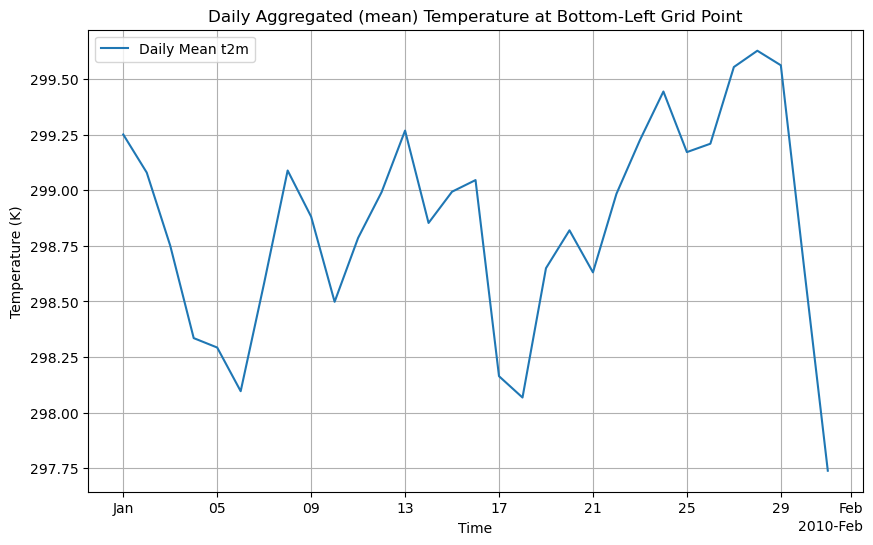

In [ ]:
# Select a specific grid point (e.g., latitude=-1, longitude=0)
variable='mean'

# note: we can use the isel method to select the grid point. In this case,
# we are selecting the bottom-left grid point (latitude=-1, longitude=0) because we're selecting
# the smallest value for latitude:
# time=0: Selects the first time point.
# latitude=-1: Selects the last latitude (bottom-most, as latitude is usually ordered from north to south).
# longitude=0: Selects the first longitude (left-most).
t2m_mean_point = daily_aggregated["t2m_" + variable].isel(latitude=-1, longitude=0)

# Plot the time series
plt.figure(figsize=(10, 6))
t2m_mean_point.plot(label="Daily Mean t2m")
plt.title("Daily Aggregated ({}) Temperature at Bottom-Left Grid Point".format(variable))
plt.xlabel("Time")
plt.ylabel("Temperature (K)")
plt.legend()
plt.grid()
plt.show()

How does this compared to the disaggregated data?

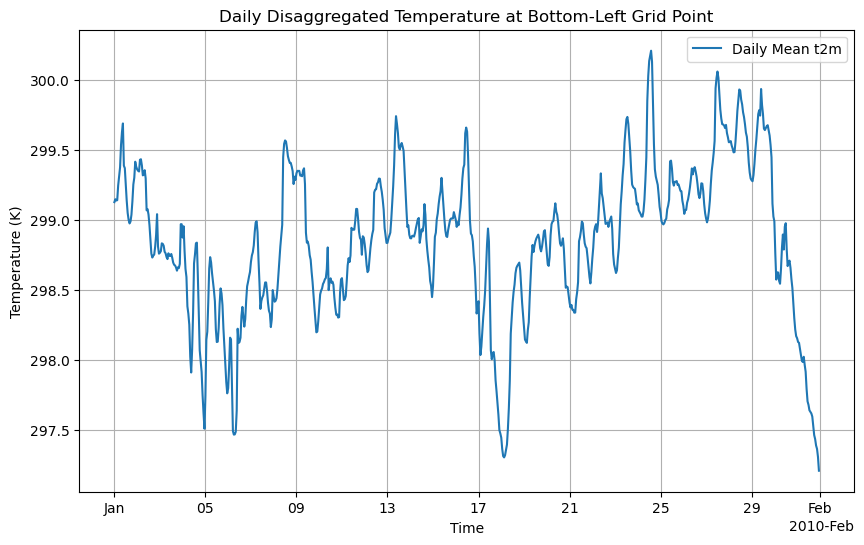

In [ ]:
t2m_point = ds["t2m"].isel(latitude=-1, longitude=0)

# Plot the time series
plt.figure(figsize=(10, 6))
t2m_point.plot(label="Daily Mean t2m")
plt.title("Daily Disaggregated Temperature at Bottom-Left Grid Point")
plt.xlabel("Time")
plt.ylabel("Temperature (K)")
plt.legend()
plt.grid()
plt.show()

These temperature plots match beautifully! This means our aggregation over the 31 days works!

Let's look at the aggregation over a map:

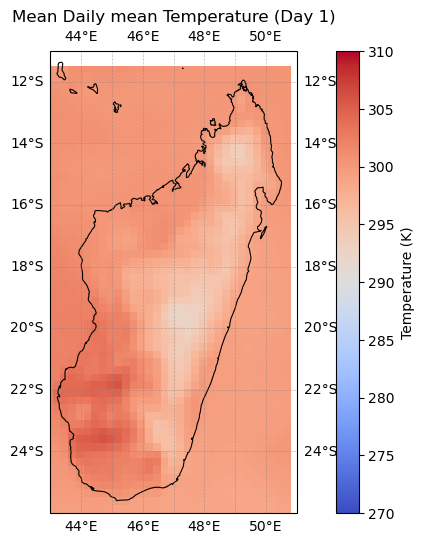

In [ ]:
# Select the first day of t2m_mean
variable="mean"
t2m_mean_day1 = daily_aggregated["t2m_" + variable].isel(valid_time=0)

# Set the absolute min and max for the color bar
vmin = 270  # Minimum value (e.g., 270 K)
vmax = 310  # Maximum value (e.g., 310 K)

# Create a plot with Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree projection for latitude/longitude data

# Plot the data
t2m_mean_day1.plot(ax=ax, cmap="coolwarm", transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Temperature (K)"})

# Add Madagascar's border using Cartopy's built-in features
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=1)  # Add country borders
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.8)  # Add coastlines

# Optionally, zoom in on Madagascar
ax.set_extent([43, 51, -26, -11], crs=ccrs.PlateCarree())  # Longitude and latitude bounds for Madagascar

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")

# Add a title
plt.title("Mean Daily {} Temperature (Day 1)".format(variable))
plt.show()

Looks great. Now, we need to see if we can do a spatial aggregation:

>A mathematical aggregation like mean() involves summarizing data values (e.g., averaging) across a specific dimension, such as time, without considering spatial relationships. For example, calculating the daily mean temperature from hourly data is purely numerical.  
In contrast, a spatial aggregation using rasters and polygons involves summarizing data based on spatial boundaries. For example, when aggregating raster data (e.g., temperature) over a polygon (e.g., a country's boundary), the process involves selecting raster cells that fall within the polygon and computing a summary statistic (e.g., mean, sum) for those spatially defined areas. This type of aggregation accounts for geographic context and spatial relationships.

To do this, we'll need to read in the shapefile that defines the shape of the polygon (ie the physical ground) and find the pixels of data that fall within the polygon. We can then use the `xarray` library to group the data by time using a resampler method. We can then use the `mean` function to calculate the average value for each day.

In [ ]:
import geopandas as gpd

# we learned how to read in shapefiles in the kenya demo notebook
zip_url_or_path = here() / "data/testing/gadm41_MDG.gpkg"

shape = gpd.read_file(zip_url_or_path, layer = "ADM_ADM_1")


We are using the layer 1 of this shapefile from GADM.org. This refers to the states in red:

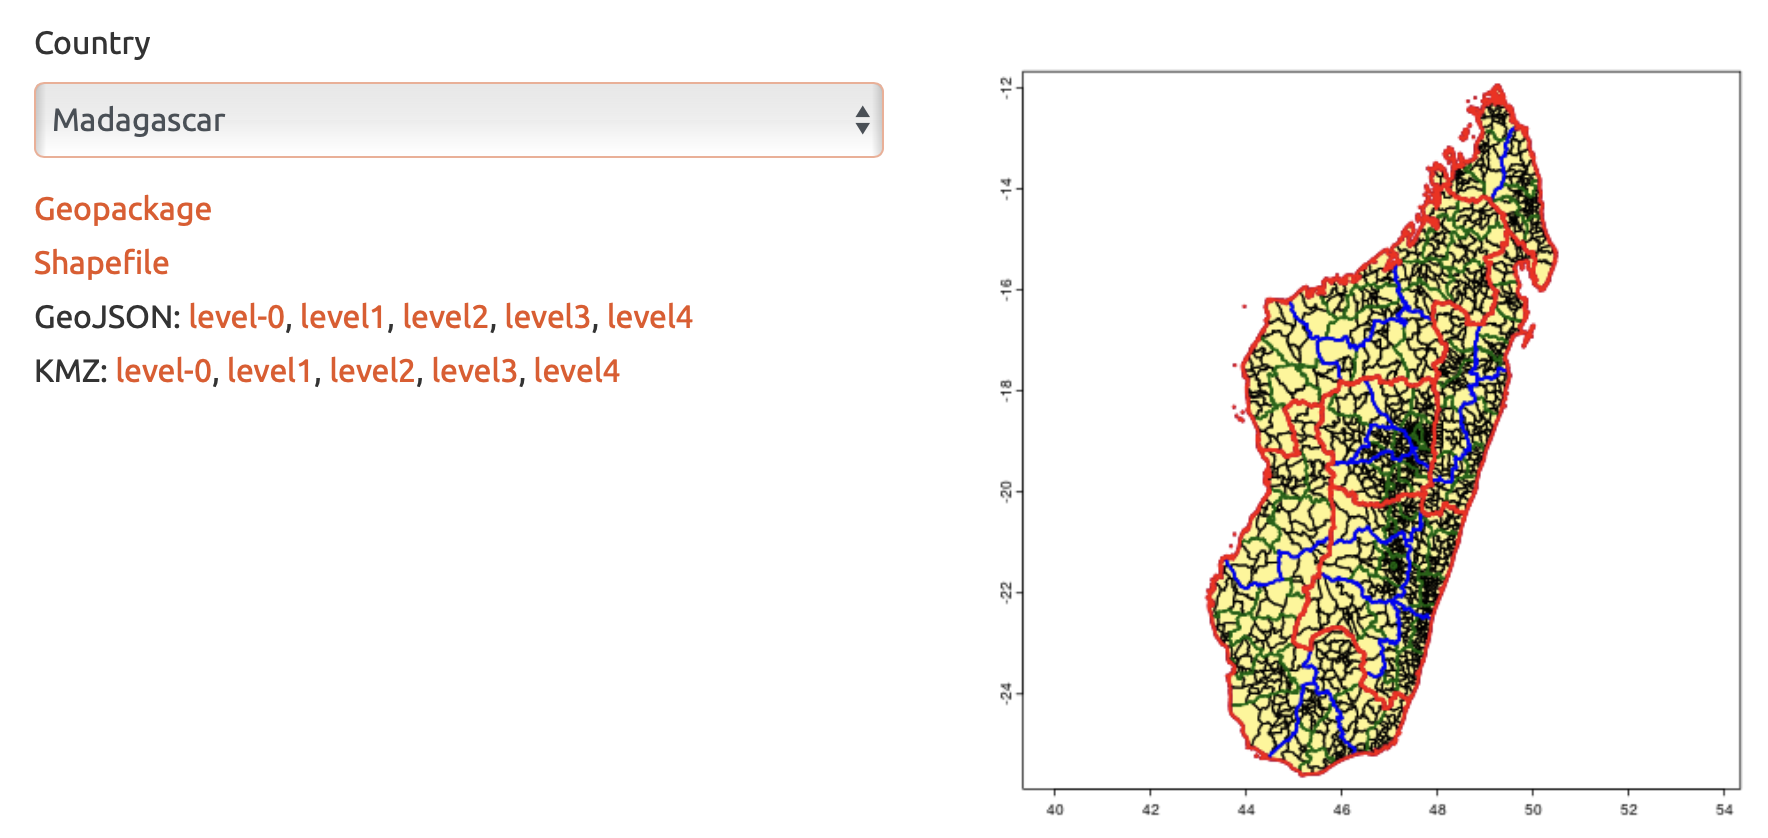

When we read in the shapefile, the data in the `geometry` column is a specification of the polygons that represent geographic boundaries.

In [ ]:
shape

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,MDG.1_1,MDG,Madagascar,Antananarivo,NA,NA,NA,NA,NA,NA,MG-T,"MULTIPOLYGON (((46.93914 -20.17013, 46.9386 -2..."
1,MDG.2_1,MDG,Madagascar,Antsiranana,NA,NA,NA,NA,NA,NA,MG-D,"MULTIPOLYGON (((50.15347 -16.0032, 50.15347 -1..."
2,MDG.3_1,MDG,Madagascar,Fianarantsoa,NA,NA,NA,NA,NA,NA,MG-F,"MULTIPOLYGON (((47.04934 -24.08504, 47.04925 -..."
3,MDG.4_1,MDG,Madagascar,Mahajanga,NA,NA,NA,NA,NA,NA,MG-M,"MULTIPOLYGON (((44.23931 -18.96421, 44.23931 -..."
4,MDG.5_1,MDG,Madagascar,Toamasina,NA,NA,NA,NA,NA,NA,MG-A,"MULTIPOLYGON (((47.67118 -20.36464, 47.6713 -2..."
5,MDG.6_1,MDG,Madagascar,Toliary,NA,NA,NA,NA,NA,NA,NA,"MULTIPOLYGON (((44.33236 -25.26931, 44.33236 -..."


In a vector image such as a shapefile, the steps between each value are not guaranteed to be equal (unlike on a cartesian plane), so we need to think about how those values "project" onto a known Coordinate Reference System (CRS) that has equal steps.

A quick note about CRS:

> The WGS 84 (World Geodetic System 1984) is a widely used global Coordinate Reference System (CRS). It is the standard CRS for GPS (Global Positioning System) and is commonly used in geospatial applications. WGS 84 defines a geographic coordinate system based on a specific ellipsoid model of the Earth.  

> Key Features of WGS 84  
Type: Geographic Coordinate System (GCS).  
Coordinates are represented in latitude, longitude, and optionally altitude.  
Units: Degrees (for latitude and longitude).  
Ellipsoid: WGS 84 uses a reference ellipsoid with:  
Semi-major axis: 6,378,137 meters.  
Flattening: 1 / 298.257223563.  
Datum: The WGS 84 datum defines the origin and orientation of the coordinate system.  
EPSG Code: The EPSG code for WGS 84 is 4326.  

Spatial geometry is complicated and silly, hence [all maps are wrong](https://youtu.be/kIID5FDi2JQ?si=OZASX3i6Aglqwa4u).

Nevertheless, we can see that the shapefile has a CRS of EPSG:4326, which is what we want:

In [ ]:
shape.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Were this different, we'd have to find some way to adjust these projections. For our netCDF file, however, we don't need to worry about this because the data themselves are created using a rasterized netCDF file, which is a standard format for storing gridded data. The data is already in a grid format, and the pixel values are already aligned with the geographic coordinates of the raster. In spatial geometry, we use degrees to represent the latitude and longitude of the corners of each pixel. This means that the data is already in a format that can be easily manipulated and analyzed using xarray and geopandas, because we refer to where the pixel is located in the world using degrees. It is essentially an absolute reference system.

In the ERA5 dataset, the resolution is said to be 0.25 degrees, which means that each pixel represents a square area of approximately 25 km x 25 km at the equator. So at every unit of 0.25 degrees north-south or east-west, we have a new pixel of data, with a value for temperature or dewpoint or whatever. You can physically see each of these on the plot.

Learn more about ERA5's resolution [here](https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference).

Now, in order to aggregate data spatially, we're pasting in a utility here for finding the intersecting values between our netcdf data and the polygons represented in our shapefile (ie the states, regions, etc.).

Source: https://github.com/NSAPH-Data-Processing/air_pollution__aqdh/blob/main/utils/faster_zonal_stats.py

In [ ]:
import numpy as np
from tqdm import tqdm
from math import ceil, floor

from rasterstats.io import Raster
from rasterstats.utils import boxify_points, rasterize_geom

This function indexes each pixel and maps it to the polygon it falls within. A few notes about this function:

- It uses the `rasterstats.io` library to read in a raster tiff file
- It uses affine transformations to convert the pixel coordinates to geographic coordinates
- It needs to know where there is no data in the raster file, so we need to set a `nodata` value
- `all_touched` is a boolean that determines whether to include all pixels that touch the polygon or just the ones that are fully contained within it; this is a domain specific choice

In [ ]:
def polygon_to_raster_cells(
    vectors,
    raster,
    band=1,
    nodata=None,
    affine=None,
    all_touched=False,
    verbose=False,
    **kwargs,
):
    """Returns an index map for each vector geometry to indices in the raster source.

    Parameters
    ----------
    vectors: list of geometries

    raster: ndarray

    nodata: float

    affine: Affine instance

    all_touched: bool, optional
        Whether to include every raster cell touched by a geometry, or only
        those having a center point within the polygon.
        defaults to `False`

    Returns
    -------
    dict
        A dictionary mapping vector the ids of geometries to locations (indices) in the raster source.
    """

    cell_map = []

    with Raster(raster, affine, nodata, band) as rast:
        # used later to crop raster and find start row and col
        min_lon, dlon = affine.c, affine.a
        max_lat, dlat = affine.f, -affine.e
        H, W = rast.shape

        for geom in tqdm(vectors, disable=(not verbose)):
            if "Point" in geom.geom_type:
                geom = boxify_points(geom, rast)

            # find geometry bounds to crop raster
            # the raster and geometry must be in the same lon/lat coordinate system
            start_row = max(0, min(H - 1, floor((max_lat - geom.bounds[3]) / dlat)))
            start_col = min(W - 1, max(0, floor((geom.bounds[0] - min_lon) / dlon)))
            end_col = max(0, min(W - 1, ceil((geom.bounds[2] - min_lon) / dlon)))
            end_row = min(H - 1, max(0, ceil((max_lat - geom.bounds[1]) / dlat)))
            geom_bounds = (
                min_lon + dlon * start_col,  # left
                max_lat - dlat * end_row - 1e-12,  # bottom
                min_lon + dlon * end_col + 1e-12,  # right
                max_lat - dlat * start_row,  # top
            )

            # crop raster to area of interest and rasterize
            fsrc = rast.read(bounds=geom_bounds)
            rv_array = rasterize_geom(geom, like=fsrc, all_touched=all_touched)
            indices = np.nonzero(rv_array)

            if len(indices[0]) > 0:
                indices = (indices[0] + start_row, indices[1] + start_col)
                assert 0 <= indices[0].min() < rast.shape[0]
                assert 0 <= indices[1].min() < rast.shape[1]
            else:
                pass  # stop here for debug

            cell_map.append(indices)

        return cell_map

So to implement this we need to first convert the netcdf to a tiff so that we can rasterize it to each of the polygons in the shapefile. We do this with `rioxarray`

In [ ]:
import rioxarray as rxr

First, we pick our variable of interest, then we set the spatial properties to make sure it conforms to the CRS we wanted

In [ ]:
temperature = daily_aggregated['t2m_mean']

In [ ]:
temp_set = temperature.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
temp_set = temp_set.rio.write_crs("EPSG:4326")

Write it out to tiff and read it back in (there's no way to do this in memory)

In [ ]:
temp_set.rio.to_raster("temp.tif")

Now we can investigate the tiff and see that it has all the properties necessary for the function

In [ ]:
import rasterio

src = rasterio.open("temp.tif")
raster = src.read(1)            # Numpy array
profile = src.profile           # Metadata
transform = src.transform

In [ ]:
# the number of data points
src.count


31

In [ ]:
# the affine transformation matrix:
#   Pixel size (resolution in x and y).
#   Origin (top-left corner in spatial coordinates).
#   Rotation (if the raster is not north-up). 
src.transform

Affine(0.25, 0.0, 42.575,
       0.0, -0.25000000000000006, -11.475)

In [ ]:
# any missing data locations
src.nodata

In [ ]:
# the number of rows and columns
print(src.width, src.height)

33 59


Fetch the array of data

In [ ]:
raster_array = src.read(1)

Function go brrrr

In [ ]:
res_poly2cell=polygon_to_raster_cells(
    vectors = shape.geometry.values, # the geometries of the shapefile of the regions
    raster=raster_array, # the raster data above
    band=1, # the value of the day that we're using
    nodata=src.nodata, # any intersections with no data, may have to be np.nan
    affine=src.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)

  0%|          | 0/6 [00:00<?, ?it/s]

/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
100%|██████████| 6/6 [00:00<00:00, 37.66it/s]


The data below maps which grid entries fall into each of the regions in the shapefile (e.g. which pixel is in which state)

In [ ]:
res_poly2cell

[(array([24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29,
         29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31,
         31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34,
         35, 35, 35, 35]),
  array([16, 13, 14, 15, 16, 17, 18, 19, 20, 21, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 11, 12, 13,
         14, 15, 16, 17, 18, 19, 20, 21, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 12,
         13, 14, 15, 16, 17, 18, 19, 20, 21, 13, 14, 15, 16, 17, 18, 19, 20,
         14, 15, 16, 17])),
 (array([ 2,  3,  3, 

In [ ]:
len(res_poly2cell)

6

Look familiar?

These are the 6 states in the shapefile. The values in the array are the indexes of the pixels in the netcdf file that fall within the polygon.
Now, within each of these we can aggregate mathematically eg min max mean etc.

In [ ]:
# the values themselves
raster_array

array([[300.87808, 300.36603, 299.68634, ..., 300.49612, 300.53604,
        300.56213],
       [300.89908, 300.4085 , 299.88904, ..., 300.50095, 300.53467,
        300.54422],
       [300.9091 , 300.75906, 300.43503, ..., 300.51334, 300.5268 ,
        300.52884],
       ...,
       [299.65125, 299.639  , 299.6254 , ..., 298.7499 , 298.93378,
        299.17337],
       [299.4636 , 299.4493 , 299.42276, ..., 298.63046, 298.7523 ,
        298.9044 ],
       [299.2504 , 299.22964, 299.1964 , ..., 298.59427, 298.63202,
        298.73044]], shape=(59, 33), dtype=float32)

In [ ]:
stats = []
for indices in res_poly2cell:
    if len(indices[0]) == 0:
        # no cells found for this polygon
        stats.append(np.nan)
    else:
        cells = raster[indices]
        if sum(~np.isnan(cells)) == 0:
            # no valid cells found for this polygon
            stats.append(np.nan)
            continue
        else:
            # compute MEAN of valid cells
            # but this stat can be ANYTHING
            stats.append(np.nanmean(cells))

In [ ]:
stats

[np.float32(296.20612),
 np.float32(298.52927),
 np.float32(298.51355),
 np.float32(299.2492),
 np.float32(296.9399),
 np.float32(301.9361)]

Looks like it worked!

In [ ]:
import pandas as pd

pd.DataFrame({"l1_region": shape.NAME_1, "mean_31_day_temp": stats})

,l1_region,mean_31_day_temp
0,Antananarivo,296.206116
1,Antsiranana,298.529266
2,Fianarantsoa,298.513550
3,Mahajanga,299.249207
4,Toamasina,296.939911
5,Toliary,301.936096


### Let's try it with Level 3 data



In [ ]:
# first get the shape of the polygons

shape = gpd.read_file(zip_url_or_path, layer = "ADM_ADM_3")

# get the new mapping of the pixels to the shapes in the region

res_poly2cell = polygon_to_raster_cells(
    vectors = shape.geometry.values, # the geometries of the shapefile of the regions
    raster=raster_array, # the raster data above
    band=1, # the value of the day that we're using
    nodata=src.nodata, # any intersections with no data, may have to be np.nan
    affine=src.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)


100%|██████████| 110/110 [00:00<00:00, 264.02it/s]


In [ ]:
len(res_poly2cell)

110

In [ ]:
# demonsttrate that because this is a "denser" set of polygons
# this iwll take longer
stats = []

for indices in res_poly2cell:
    if len(indices[0]) == 0:
        # no cells found for this polygon
        stats.append(np.nan)
    else:
        cells = raster[indices]
        if sum(~np.isnan(cells)) == 0:
            # no valid cells found for this polygon
            stats.append(np.nan)
            continue
        else:
            # compute mean of valid cells
            stats.append(np.nanmean(cells))

In [ ]:
stats

[np.float32(295.27213),
 np.float32(293.5218),
 np.float32(295.74274),
 np.float32(296.6221),
 np.float32(294.4437),
 np.float32(294.15137),
 np.float32(294.45166),
 np.float32(294.1732),
 np.float32(297.0975),
 np.float32(297.86023),
 np.float32(294.1745),
 np.float32(296.0813),
 np.float32(296.35345),
 np.float32(293.1277),
 np.float32(293.0299),
 np.float32(293.55472),
 np.float32(292.9831),
 np.float32(296.97507),
 np.float32(294.04526),
 np.float32(297.41995),
 np.float32(297.34006),
 np.float32(299.97202),
 np.float32(298.99017),
 np.float32(299.4947),
 np.float32(296.48395),
 np.float32(299.19806),
 np.float32(297.50873),
 np.float32(298.88483),
 np.float32(298.054),
 np.float32(294.57904),
 np.float32(293.75),
 np.float32(294.3333),
 np.float32(296.7462),
 np.float32(299.78516),
 np.float32(296.98166),
 np.float32(298.6441),
 np.float32(298.45975),
 np.float32(297.95724),
 np.float32(294.80765),
 np.float32(295.85223),
 np.float32(295.08646),
 np.float32(299.95883),
 np.float32

Now we have 110 mean temperatuers for each of the shapefile's regions.

In [ ]:

df = pd.DataFrame(
            {"l3_territory": shape.NAME_3, "dummy_date_in_future": 1, "temp_vals": stats}
        )

In [ ]:
df

,l3_territory,dummy_date_in_future,temp_vals
0,Ambohidratrimo,1,295.272125
1,Andramasina,1,293.521790
2,Anjozorobe,1,295.742737
3,Ankazobe,1,296.622101
4,Antananarivo-Nord,1,294.443695
...,...,...,...
105,Belon-i Tsiribihina,1,302.330322
106,Mahabo,1,302.211365
107,Manja,1,303.465607
108,Miandrivazo,1,300.230927


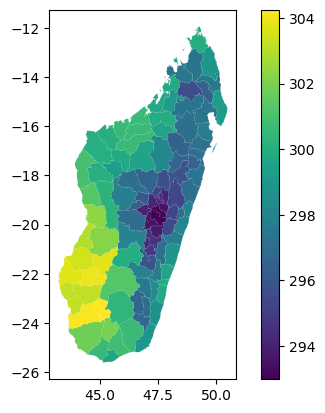

In [ ]:
# now we plot it using the shape.geometry to get the shapefile's location for each region
gdf = gpd.GeoDataFrame(df, geometry=shape.geometry.values, crs=shape.crs)
gdf.plot(column="temp_vals", legend=True)
plt.show()

We can test this out with our healthsheds file

In [ ]:
healthsheds = gpd.read_file(here() / "data/testing/mdg_healthsheds2022")

In [ ]:
healthsheds

,fs_uid,fs_pop,n_uid,n_instat,reg_uid,reg_name,dist_uid,dist_name,fs_type,fs_name,fs_ll,n_comp,n_shape,geometry
0,A0YU5ksfXZS,13014,6,6,O0yrAFTjghG,Vatovavy,hBOXdumAvNc,Mananjary,CSB2,CSB2 Morafeno,POINT (48.180332 -21.097472),1.0,1,"POLYGON ((48.21537 -20.95662, 48.21593 -20.956..."
1,A1SY9AiVPYF,3103,4,4,I9lEj4mALls,Analamanga,vHRv6NgA70x,Manjakandriana,CSB1,CSB1 Ambohidraisolo,POINT (47.879317 -19.161348),1.0,1,"POLYGON ((47.85923 -19.09954, 47.8601 -19.0998..."
2,A38WhL0NPsX,2344,3,3,O0yrAFTjghG,Vatovavy,hBOXdumAvNc,Mananjary,CSB2,CSB2 Mahatsara Iefaka,POINT (48.326937 -21.11468),1.0,1,"POLYGON ((48.35588 -21.05353, 48.35801 -21.057..."
3,A6fVNQgqqJg,7494,5,5,kgGIXgdG56r,Haute Matsiatra,BU35owjfn8G,Vohibato,CSB2,CSB2 Ankaromalaza,None,1.0,1,"POLYGON ((47.18552 -21.70624, 47.19275 -21.711..."
4,A77QRkmKUul,8387,5,4,I9lEj4mALls,Analamanga,dsDbxSkO1ST,Andramasina,CSB1,CSB1 Mangabe,POINT (47.716094 -19.176215),1.0,1,"POLYGON ((47.73249 -19.15372, 47.73267 -19.153..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,zw74in2A9Vn,4580,5,5,A8UMJuP8iI3,Boeny,ffiVmdBUwzI,Marovoay,CSB2,CSB2 Ampijoroa Nord,None,1.0,1,"POLYGON ((46.73145 -16.12848, 46.73365 -16.131..."
2769,zwhfpU5j9aV,7440,5,5,PTqLWwjcAox,Anosy,KBe7h4EfJDf,Taolagnaro,CSB2,CSB2 Tanandava,None,1.0,1,"POLYGON ((47.00558 -24.44654, 47.00489 -24.446..."
2770,zwyM0iDw9X7,5705,3,3,wR0PL2iap0s,Atsinanana,xgvRu8zZAZK,Marolambo,CSB1,CSB1 Maroariana I,POINT (47.948408 -20.025144),1.0,1,"POLYGON ((47.95335 -19.9937, 47.95573 -20.0087..."
2771,zxQu4lRMMP9,7647,6,5,zJ9UJ7RhCwV,Diana,s3HejcPkUeJ,Antsiranana II,CSB2,CSB2 Antsalaka,POINT (49.251201 -12.640404),1.0,1,"POLYGON ((49.27604 -12.6479, 49.27603 -12.6479..."


In [ ]:
# there are NAs to remove
healthsheds.dropna(subset = ['geometry'], inplace=True)

In [ ]:
len(set(healthsheds.fs_uid))

2766

In [ ]:
# get the new mapping of the pixels to the shapes in the region

res_poly2cell = polygon_to_raster_cells(
    vectors = healthsheds.geometry.values, # the geometries of the shapefile of the regions
    raster=raster_array, # the raster data above
    band=1, # the value of the day that we're using
    nodata=src.nodata, # any intersections with no data, may have to be np.nan
    affine=src.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)

stats = []

for indices in res_poly2cell:
    if len(indices[0]) == 0:
        # no cells found for this polygon
        stats.append(np.nan)
    else:
        cells = raster[indices]
        if sum(~np.isnan(cells)) == 0:
            # no valid cells found for this polygon
            stats.append(np.nan)
            continue
        else:
            # compute mean of valid cells
            stats.append(np.nanmean(cells))

  0%|          | 0/2766 [00:00<?, ?it/s]

100%|██████████| 2766/2766 [00:01<00:00, 1629.20it/s]


In [ ]:
df = pd.DataFrame(
            {"healthshed": healthsheds.fs_uid, "dummy_date_in_future": 1, "temp_vals": stats}
        )

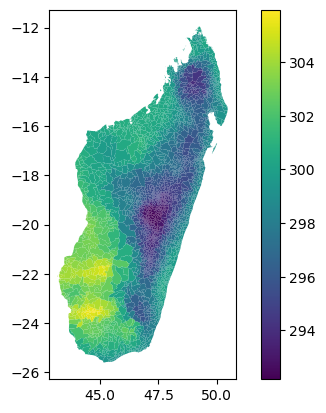

In [ ]:
# now we plot it using the shape.geometry to get the shapefile's location for each region
gdf = gpd.GeoDataFrame(df, geometry=healthsheds.geometry.values, crs=shape.crs)
gdf.plot(column="temp_vals", legend=True)
plt.show()

Now that we've demonstrated how this could work, we can substitute the GADM shapefiles for our healthsheds, and put it in a pipeline!!!

## Nepal

We've modified the pipeline to now download Nepal as well. We'll test out an aggregation using the aggregation shapefiles we were provided by Dimeji. We probably want to decide on where to centralize data storage for files like this

In [ ]:
try: from era5_sandbox.core import GoogleDriver, _get_callable, describe
except: from core import GoogleDriver, _get_callable, describe

try: from era5_sandbox.download import download_raw_era5
except: from download import download_raw_era5

try: from era5_sandbox.aggregate import resample_netcdf, netcdf_to_tiff, polygon_to_raster_cells, aggregate_to_healthsheds
except: from aggregate import resample_netcdf, netcdf_to_tiff, polygon_to_raster_cells, aggregate_to_healthsheds

In [ ]:
from hydra import initialize, compose
from omegaconf import OmegaConf

# unfortunately, we have to use the initialize function to load the config file
# this is because the @hydra decorator does not work with Notebooks very well
# this is a known issue with Hydra: https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248
# 
# just use the relative path from the notebook to the config dir
with initialize(version_base=None, config_path="../../conf"):
    cfg = compose(config_name='config.yaml')

cfg.development_mode = False
cfg.query['year'] = 2023
cfg.query['month'] = 10
cfg.query['day'] = 1
cfg.query['time'] = "00:00"
cfg.query['geography'] = "nepal"
download_raw_era5(cfg)

2025-04-22 15:40:17,129 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-22 15:40:17,130 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-22 15:40:21,113 INFO Request ID is ef1937bd-855a-4651-af70-550b72415172
2025-04-22 15:40:21,266 INFO status has been updated to accepted
2025-04-22 15:40:35,703 INFO status has been updated to successful
                                                                                         

Done


Now let's read it in and run the aggregation:

In [ ]:
# Load the NetCDF file
fpath = here() / "data/input/nepal_2023_10.nc"
ds = xr.open_dataset(fpath)

In [ ]:
ds

<xarray.Dataset> Size: 6kB
Dimensions:     (valid_time: 1, latitude: 20, longitude: 37)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2023-10-01
  * latitude    (latitude) float64 160B 30.75 30.5 30.25 ... 26.5 26.25 26.0
  * longitude   (longitude) float64 296B 79.6 79.85 80.1 ... 88.1 88.35 88.6
    expver      <U4 16B ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 3kB ...
    t2m         (valid_time, latitude, longitude) float32 3kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-18T18:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# Perform multiple aggregations
daily_mean = ds.resample(valid_time="1D").mean()  # Daily mean
daily_max = ds.resample(valid_time="1D").max()   # Daily max
daily_min = ds.resample(valid_time="1D").min()   # Daily min

# Combine the results into a new dataset
daily_aggregated = xr.Dataset({
    "t2m_mean": daily_mean["t2m"],
    "t2m_max": daily_max["t2m"],
    "t2m_min": daily_min["t2m"],
    "d2m_mean": daily_mean["d2m"],
    "d2m_max": daily_max["d2m"],
    "d2m_min": daily_min["d2m"]
})

daily_aggregated

<xarray.Dataset> Size: 18kB
Dimensions:     (latitude: 20, longitude: 37, valid_time: 1)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 160B 30.75 30.5 30.25 ... 26.5 26.25 26.0
  * longitude   (longitude) float64 296B 79.6 79.85 80.1 ... 88.1 88.35 88.6
    expver      <U4 16B '0001'
  * valid_time  (valid_time) datetime64[ns] 8B 2023-10-01
Data variables:
    t2m_mean    (valid_time, latitude, longitude) float32 3kB 271.0 ... 300.9
    t2m_max     (valid_time, latitude, longitude) float32 3kB 271.0 ... 300.9
    t2m_min     (valid_time, latitude, longitude) float32 3kB 271.0 ... 300.9
    d2m_mean    (valid_time, latitude, longitude) float32 3kB 269.4 ... 299.8
    d2m_max     (valid_time, latitude, longitude) float32 3kB 269.4 ... 299.8
    d2m_min     (valid_time, latitude, longitude) float32 3kB 269.4 ... 299.8

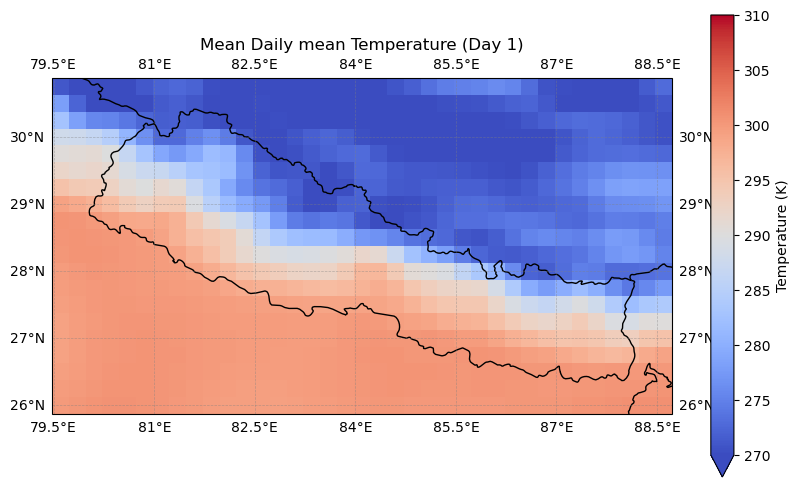

In [ ]:
# Select the first day of t2m_mean
variable="mean"
t2m_mean_day1 = daily_aggregated["t2m_" + variable].isel(valid_time=0)

# Set the absolute min and max for the color bar
vmin = 270  # Minimum value (e.g., 270 K)
vmax = 310  # Maximum value (e.g., 310 K)

# Create a plot with Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree projection for latitude/longitude data

# Plot the data
t2m_mean_day1.plot(ax=ax, cmap="coolwarm", transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Temperature (K)"})

# Add Madagascar's border using Cartopy's built-in features
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=1)  # Add country borders
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.8)  # Add coastlines

# Optionally, zoom in on Madagascar
#ax.set_extent([43, 51, -26, -11], crs=ccrs.PlateCarree())  # Longitude and latitude bounds for Madagascar

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")

# Add a title
plt.title("Mean Daily {} Temperature (Day 1)".format(variable))
plt.show()

We're going to create the aggregations using the function we defined in the aggregate module

In [ ]:
resampled_nc = resample_netcdf(fpath)

resampled_tiff = netcdf_to_tiff(
    ds=resampled_nc,
    variable="t2m",
    crs="EPSG:4326"
)

Now we fetch the shapefile for administrative aggregations using our googledriver class:

In [ ]:
driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
drive = driver.get_drive()

In [ ]:
shape = "Nepal_Healthsheds2024.zip"

In [ ]:
healthsheds = driver.read_healthsheds(shape)

In [ ]:
healthsheds.columns

Index(['fid', 'STATE_CODE', 'DISTRICT', 'GaPa_NaPa', 'Type_GN', 'Province',
       'geometry', 'mean_temperature'],
      dtype='object')

In [ ]:
healthsheds.describe()

,fid,STATE_CODE,mean_temperature
count,777.000000,777.000000,777.000000
mean,389.000000,3.651223,293.174866
std,224.444871,2.000799,6.550984
min,1.000000,1.000000,270.501404
25%,195.000000,2.000000,290.117432
50%,389.000000,3.000000,294.104492
75%,583.000000,5.000000,298.800537
max,777.000000,7.000000,300.483398


In [ ]:
len(set(healthsheds['fid'].values))

777

In [ ]:
res_poly2cell=polygon_to_raster_cells(
    vectors = healthsheds.geometry.values, # the geometries of the shapefile of the regions
    raster=resampled_tiff.data, # the raster data above
    band=1, # the value of the day that we're using
    nodata=resampled_tiff.nodata, # any intersections with no data, may have to be np.nan
    affine=resampled_tiff.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)

100%|██████████| 777/777 [00:00<00:00, 1125.83it/s]


In [ ]:
result = aggregate_to_healthsheds(
    res_poly2cell=res_poly2cell,
    raster=resampled_tiff,
    shapes=healthsheds,
    names_column="fid",
    aggregation_func=np.nanmean,
    aggregation_name="mean_temperature"
)
result.head()

,healthshed,mean_temperature,geometry
0,1,292.330078,"POLYGON ((87.60719 27.37069, 87.60841 27.36969..."
1,7,286.162109,"POLYGON ((88.04438 27.4203, 88.04365 27.41925,..."
2,8,282.460938,"POLYGON ((88.14528 27.67003, 88.14526 27.66966..."
3,23,293.310547,"POLYGON ((88.0766 27.03545, 88.07695 27.03533,..."
4,24,295.396484,"POLYGON ((87.76435 26.92431, 87.76435 26.924, ..."


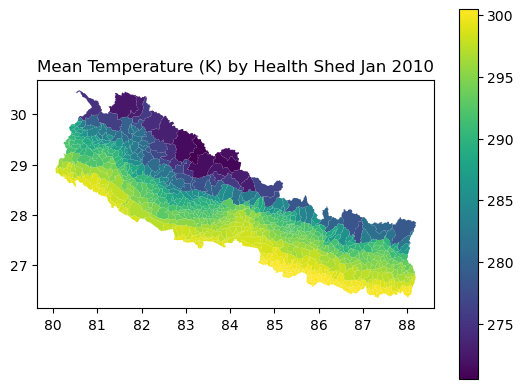

In [ ]:
result.plot(column="mean_temperature", legend=True)
plt.title("Mean Temperature (K) by Health Shed October 2023")
plt.show()

This should work by slotting right into the pipeline, only changing the function for the names column